In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from numpy import fft

from IPython.html import widgets

%matplotlib inline

## Image Processing in OpenCV
- [resource](http://docs.opencv.org/trunk/doc/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html#py-table-of-content-imgproc)
- [segmentation on watershed](http://cmm.ensmp.fr/~beucher/wtshed.html)

## Topic: Image Segmentation
- marker-based segmentation such as watershed algorithm
- interactive segementation (foreground extraction) such as GrabCut algorithm

#### Footnote - Distance Transformation
The [distance transform](http://homepages.inf.ed.ac.uk/rbf/HIPR2/distance.htm) is an operator normally only applied to binary images. The result of the transform is a graylevel image that looks similar to the input image, except that the graylevel intensities of points inside foreground regions are changed to show the distance to the closest boundary from each point.

#### Footnote - Connected Components (as for marker creation)
cv2.connectedComponents labels background of the image with 0, then other objects are labelled with integers starting from 1.

### Watershed for Image Segmentation

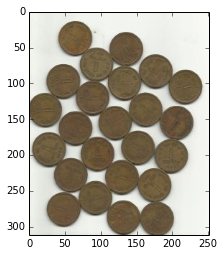

In [2]:
coins = cv2.imread("public-images/coins.jpg")[:,:,::-1]
gray_coins = cv2.cvtColor(coins, cv2.COLOR_RGB2GRAY)
plt.imshow(coins)

162.0
uint8 uint8


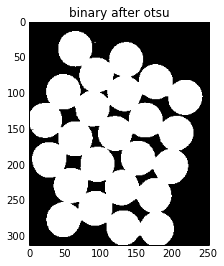

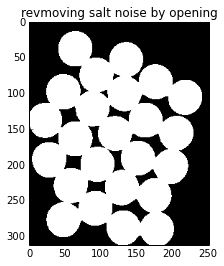

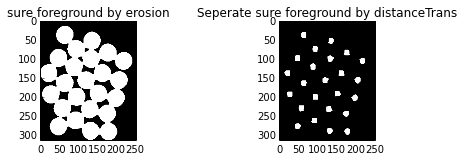

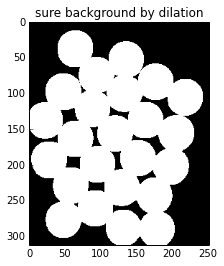

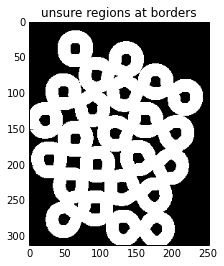

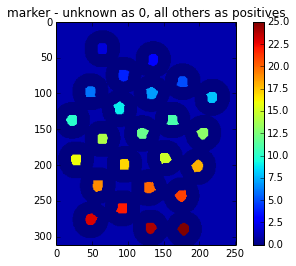

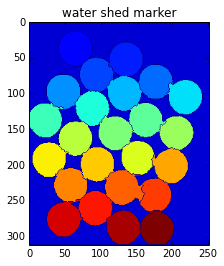

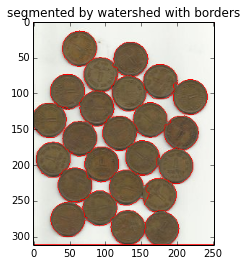

In [5]:
## method1 

## step 1 - use otus binarization to segement image
thr, otsu_binary = cv2.threshold(gray_coins, 0, 255, 
                                 cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)
print thr
plt.imshow(otsu_binary, cmap = plt.cm.gray)
plt.title("binary after otsu")

## step 2 - removing small salt noise by opening (erosion -> dialation)
## we don't see obvious holes (pepper noise), so need for closing
kernel = np.ones((3, 3), dtype=np.uint8)
opening = cv2.morphologyEx(otsu_binary, cv2.MORPH_OPEN, kernel, )
plt.figure()
plt.imshow(opening, cmap = plt.cm.gray)
plt.title("revmoving salt noise by opening")

## step 3 - finding foreground with confidence
## ususally erosion will do the job, if the parts are not connected, OR FOREGROUND AS A WHOLE
## IS THE INTEREST
## so here a better opion is to find the distance transform and apply proper thr
sure_fg_erosion = cv2.erode(opening, kernel, )
plt.figure()
fig, axes = plt.subplots(1, 2)
fig.subplots_adjust(wspace = 1.5)
axes[0].imshow(sure_fg_erosion, cmap = plt.cm.gray)
axes[0].set_title("sure foreground by erosion")

sure_fg_dist = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
thr, sure_fg_dist = cv2.threshold(sure_fg_dist, 0.7*sure_fg_dist.max(), 
                                 255, cv2.THRESH_BINARY)
sure_fg_dist = sure_fg_dist.astype(np.uint8)
axes[1].imshow(sure_fg_dist, cmap = plt.cm.gray)
axes[1].set_title("Seperate sure foreground by distanceTrans")

## step 4 - finding background with confidence
## a dialation will do the job
sure_bg_dilation = cv2.dilate(opening, np.ones((3, 3)))
plt.figure()
plt.imshow(sure_bg_dilation, cmap = plt.cm.gray)
plt.title("sure background by dilation")

## step 5 - the remaining regioins are those we are NOT sure of.
## watershed is used to find them - these are usually regions at boundaries where
## foreground and background meet. 
## IF WE USE EROSION AS SURE-FOREGROUND, AND DIALATION AS SURE-BACKGROUND
## BORDERS ARE ESSENTIALLY MORPHLOGICAL_GRADIENT
print sure_bg_dilation.dtype, sure_fg_dist.dtype
unknown = cv2.subtract(sure_bg_dilation, sure_fg_dist, )
plt.figure()
plt.imshow(unknown, cmap = plt.cm.gray)
plt.title("unsure regions at borders")

## step 6 - create marker img (int32, same size of original image)
## The regions we know for sure (whether foreground or background) are 
## labelled with any positive integers, but different integers, 
## and the area we donâ€™t know for sure are just left as zero.
ret, markers = cv2.connectedComponents(sure_fg_dist, )
## make the background as 1, not 0 (for unknown)
markers = markers + 1
## mark any unknown as 0
markers[unknown==255] = 0
plt.figure()
plt.imshow(markers, cmap = plt.cm.jet)
plt.title("marker - unknown as 0, all others as positives")
plt.colorbar()

## step 7 - use watershed after getting markers
## watershed only needs the marker image, and will mark the border as -1
water_shed = cv2.watershed(coins, markers.copy())
plt.figure()
plt.imshow(water_shed)
plt.title("water shed marker")
segmented_coins = coins.copy()
segmented_coins[water_shed==-1] = (255, 0, 0)
plt.figure()
plt.imshow(segmented_coins)
plt.title("segmented by watershed with borders")

### GrabCut for Foreground Extraction

- gimp has a plugin implementation
- `cv2.grabCut()`

In [ ]:
img = cv2.imread('public-images/messi5.jpg')
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img)
plt.colorbar()